In [6]:
from deepthought.util.crossvalidation_util import ClassificationResult
from deepthought.util import fs_util

import logging
logging.basicConfig(level=logging.INFO)
#logging.getLogger('deepthought.datasets').setLevel(logging.DEBUG) # debug dataset

In [7]:
results = dict()
meta = [
    ('SVC_baseline', 'results/raw_openmiir_baseline/linear_svc_result.pklz'),
    ('SVC_baseline_mean', 'results/raw_openmiir_baseline_chmean/linear_svc_result.pklz'),
    ('MLP_End-to-End', 'results/raw_openmiir_e2e_simpleconv_ep100/mlp_result.pklz'),
    ('SVC_Siamese', 'results/raw_openmiir_siamese_simpleconv_L1norm_margin-0.5/linear_svc_result.pklz'),
    ('SVC_TripletNet', 'results/raw_openmiir_tripletnet_simpleconv/linear_svc_result.pklz'),
    ('MLP_SCE', 'results/raw_openmiir_sce_simpleconv_dotprod/simple_nn_result.pklz'),
    ('SVC_SCE', 'results/raw_openmiir_sce_simpleconv_dotprod/linear_svc_result.pklz'),
]


for (k,v) in meta:
    print k, v
    results[k] = fs_util.load(v)

SVC_baseline results/raw_openmiir_baseline/linear_svc_result.pklz
SVC_baseline_mean results/raw_openmiir_baseline_chmean/linear_svc_result.pklz
MLP_End-to-End results/raw_openmiir_e2e_simpleconv_ep100/mlp_result.pklz
SVC_Siamese results/raw_openmiir_siamese_simpleconv_L1norm_margin-0.5/linear_svc_result.pklz
SVC_TripletNet results/raw_openmiir_tripletnet_simpleconv/linear_svc_result.pklz
MLP_SCE results/raw_openmiir_sce_simpleconv_dotprod/simple_nn_result.pklz
SVC_SCE results/raw_openmiir_sce_simpleconv_dotprod/linear_svc_result.pklz


In [8]:
for (k,v) in meta:
    print k, 100*(1.-results[k].test_error())

SVC_baseline 18.5185185185
SVC_baseline_mean 12.4074074074
MLP_End-to-End 18.1481481481
SVC_Siamese 12.962962963
SVC_TripletNet 25.5555555556
MLP_SCE 27.2222222222
SVC_SCE 27.5925925926


In [9]:
# see http://bmcmedresmethodol.biomedcentral.com/articles/10.1186/1471-2288-13-91
# from http://pastebin.com/2iC5yAKX
from scipy.stats import binom 
def mcnemar_midp(b, c):
    """
    Compute McNemar's test using the "mid-p" variant suggested by:
   
    M.W. Fagerland, S. Lydersen, P. Laake. 2013. The McNemar test for
    binary matched-pairs data: Mid-p and asymptotic are better than exact
    conditional. BMC Medical Research Methodology 13: 91.
   
    `b` is the number of observations correctly labeled by the first---but
    not the second---system; `c` is the number of observations correctly
    labeled by the second---but not the first---system.
    """
    n = b + c
    x = min(b, c)
    dist = binom(n, .5)
    p = 2. * dist.cdf(x)
    midp = p - dist.pmf(x)
    return midp

import numpy as np
from scipy import stats

def mcnemars_test(a, b, verbose=False):
    assert np.all(a.test_Y_real == b.test_Y_real)
    
    N = len(a.test_Y_real)
    
    #acc_a = 100. * float(sum(a.test_Y_real == a.test_Y_pred) / len(a.test_Y_real))
    acc_a = 100. * np.mean(a.test_Y_real == a.test_Y_pred)
    if verbose: print acc_a
    #acc_b = 100. * float(sum(b.test_Y_real == b.test_Y_pred) / len(b.test_Y_real))
    acc_b = 100. * np.mean(b.test_Y_real == b.test_Y_pred)
    if verbose: print acc_b
    
    at = np.where(a.test_Y_real == a.test_Y_pred)[0] # A correct
    af = np.where(a.test_Y_real != a.test_Y_pred)[0] # A wrong
    #print at
    if verbose: print 'A correct', len(at), len(at)/float(N)
    #print af
    if verbose: print 'A wrong  ', len(af), len(af)/float(N)
    bt = np.where(b.test_Y_real == b.test_Y_pred)[0] # B correct
    bf = np.where(b.test_Y_real != b.test_Y_pred)[0] # B wrong
    #print bt
    if verbose: print 'B correct', len(bt), len(bt)/float(N)
    #print bf
    if verbose: print 'B wrong  ', len(bf), len(bf)/float(N)
    
    n_tt = 0 # both correct
    n_ft = 0 # only B correct 
    n_tf = 0 # only A correct
    n_ff = 0 # both wrong
    for x in at:
        if x in bt: 
            n_tt += 1
        else:
            n_tf += 1
    for x in af:
        if x in bf: 
            n_ff += 1
        else:
            n_ft += 1

    if verbose: print n_tt, n_tf
    if verbose: print n_ft, n_ff
    
#    m =           (abs(n01-n10) - 1) ** 2 / float(n01+n01) <- MISTAKE - 2x same value n01
#    chi2testval = (abs(n01-n10) - 1) ** 2 / float(n01+n10)
#   
#    m = (abs(n_tf-n_ft) - 1) ** 2 / float(n_tf+n_ft)
#    print m

    if n_tf == n_ft:
        return 1.
                                    
    mcnemar = abs(n_tf - n_ft)**2 / float(n_tf + n_ft)
    deg_of_freedom = 1
    pvalue = 1 - stats.chi2.cdf(mcnemar, deg_of_freedom)
    
    #print 'first classifier: ', n_tf      
    #print 'second classifier:', n_ft
    if verbose: print 'McNemar statistic:', mcnemar
    if verbose: print 'P-value: ', pvalue
    
    mcnemar_mp = mcnemar_midp(n_tf, n_ft)
    if verbose: print 'Mid-P-value: ', mcnemar_mp
    return mcnemar_mp

In [10]:
names = [
'SVC, raw EEG (1)',
'SVC, raw EEG channel mean (2)',
'End-to-end NN, raw EEG',
'SVC, siamese net output',
'SVC, triplet net output',
'NN, SCE output',
'SVC, SCE output',
    ]

#stats = np.zeros((len(jobs), len(jobs)))
for i, (job, _) in enumerate(meta):
    n_correct = (1 - results[job].test_error()) * 540    
    p = binom.cdf(n_correct, n=540, p=1./12)
    alpha = (1-p)/540.
    #print n_correct, p, alpha
    print '{:30} & {:.2f}\\% & {:.5f} \\\\'.format(names[i], 
                                      100 * (1-results[job].test_error()),
                                      mcnemars_test(results['SVC_SCE'], results[job]),
                                     )

SVC, raw EEG (1)               & 18.52\% & 0.00020 \\
SVC, raw EEG channel mean (2)  & 12.41\% & 0.00000 \\
End-to-end NN, raw EEG         & 18.15\% & 0.00014 \\
SVC, siamese net output        & 12.96\% & 0.00000 \\
SVC, triplet net output        & 25.56\% & 0.29423 \\
NN, SCE output                 & 27.22\% & 0.81512 \\
SVC, SCE output                & 27.59\% & 1.00000 \\


# plot weights

In [11]:
import matplotlib
%matplotlib inline

In [12]:
import mne
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

def plot_topomaps(topomaps, layout=None, labels=None, show=True, **params):
    if layout is None:
        from mne.channels import read_layout
        layout = mne.channels.read_layout('biosemi.lay')

    if not 'contours' in params:
        params['contours'] = False

    topomaps = np.asarray(topomaps)
    for i in range(3 - topomaps.ndim):
        topomaps =[topomaps]
    topomaps = np.asarray(topomaps)

    if not 'vmax' in params:
        params['vmax'] = abs(topomaps).max()
    if not 'vmin' in params:
        params['vmin'] = -abs(topomaps).max()

#     print topomaps.shape
    rows, cols, _ = topomaps.shape
    subplot_grid = gridspec.GridSpec(rows,cols)
    k = 0
    for r in range(rows):
        for c in range(cols):
            ax = plt.subplot(subplot_grid[r,c])
            data = topomaps[r,c,:]
            mne.viz.plot_topomap(data, layout.pos, names=layout.names, axes=ax, show=False, **params)

            if labels is not None:
                ax.set_title(labels[k])
            k += 1
    if show:
        plt.show()

    return subplot_grid

def resize(w=17, h=10):
    plt.gcf().set_size_inches(w, h, forward=True) # trick to increase size for show=False


In [45]:
def load_params(job, param_name=None, folds=None):
    if folds is None:
        folds = np.arange(9)

    import deepthought.util.fs_util as fs_util
    
    fold_params = [fs_util.load('results/{}/fold_params_{}.pklz'.format(job, f)) for f in folds]
        
    if param_name is not None:
        fold_params = [[ifp[param_name] for ifp in ofp] for ofp in fold_params]

    return fold_params

def load_spatial_filters(job, folds=None):
    if folds is None:
        folds = np.arange(9)

    fold_weights = load_params(job, '/pipeline/conv.W', folds)
    fold_weights = np.concatenate(fold_weights, axis=0)
#     print fold_weights.shape
        
    fold_polarity = np.sign(fold_weights[:,0,14,0,0])
    fold_weights = np.asarray([p*w for p,w in zip(fold_polarity, fold_weights)])

    return fold_weights 

In [14]:
def analyze_encoder_weights(job):
    print job
    fold_params = load_params(job, '/pipeline/conv.W')
    fold_params = np.asarray(fold_params)
    
    print fold_params.shape
    fold_polarity = np.sign(fold_params[:,:,0,14,0,0])
    
    for i in range(fold_polarity.shape[0]):
        for j in range(fold_polarity.shape[1]):
            fold_params[i,j] *= fold_polarity[i,j]
            #fold_params[i,j] /= max(abs(fold_params[i,j]))
            
    #fold_params = np.asarray([p*w for p,w in zip(fold_polarity, fold_params)])
    
    plot_topomaps(fold_params.squeeze(), show=False)
    resize(15,27)
    plt.show()
    
    plot_topomaps(fold_params.mean(axis=1).squeeze(), show=False)
    resize(17,3)
    plt.show()
    
    plot_topomaps(fold_params.mean(axis=0).mean(axis=0).squeeze())

raw_openmiir_sce_simpleconv_dotprod
(9, 5, 1, 64, 1, 1)


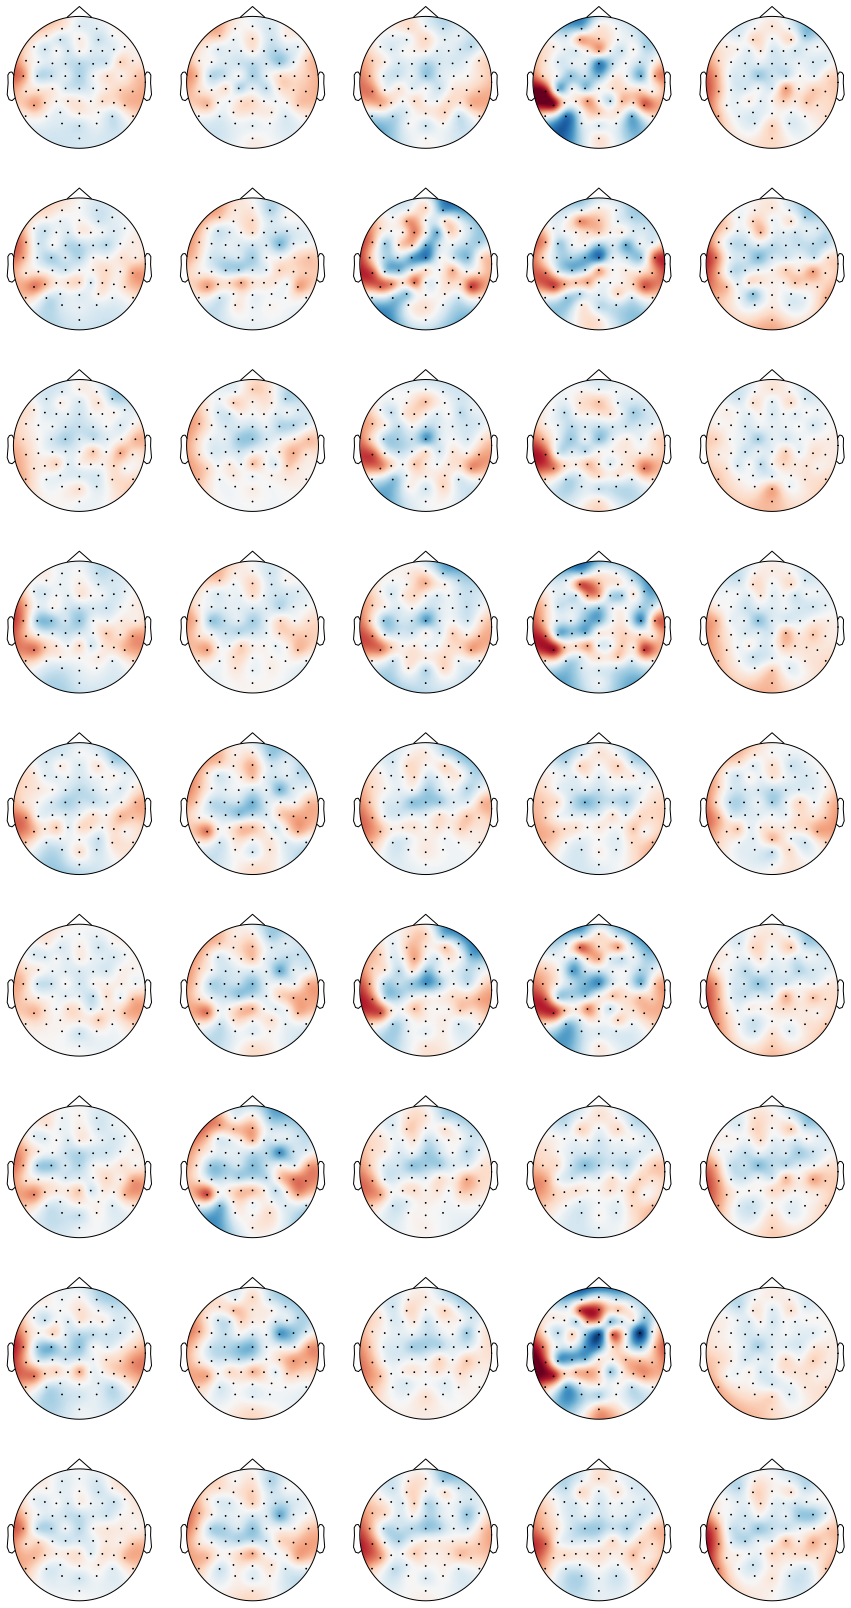

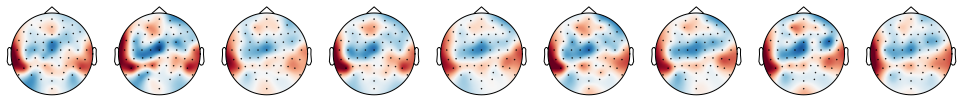

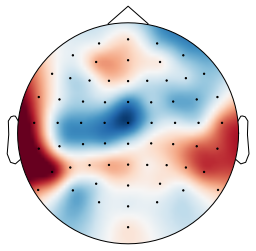

In [74]:
analyze_encoder_weights('raw_openmiir_sce_simpleconv_dotprod')

raw_openmiir_tripletnet_simpleconv
(9, 5, 1, 64, 1, 1)


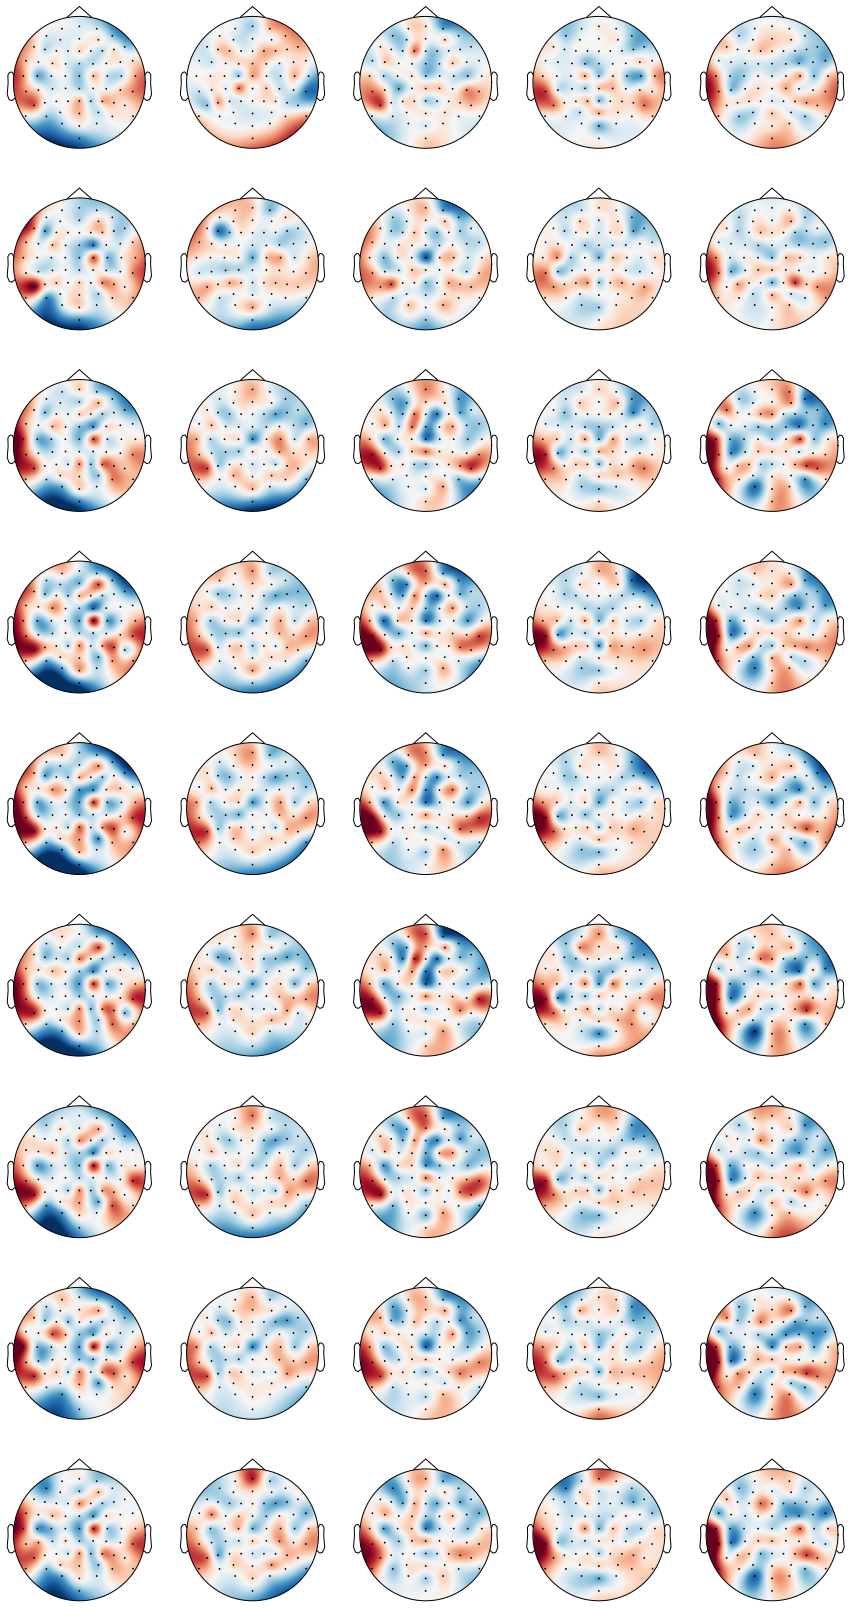

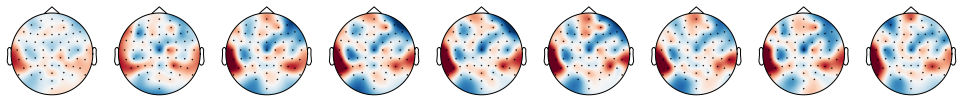

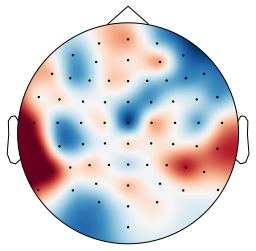

In [75]:
analyze_encoder_weights('raw_openmiir_tripletnet_simpleconv')

raw_openmiir_siamese_simpleconv_dotprod
(9, 5, 1, 64, 1, 1)


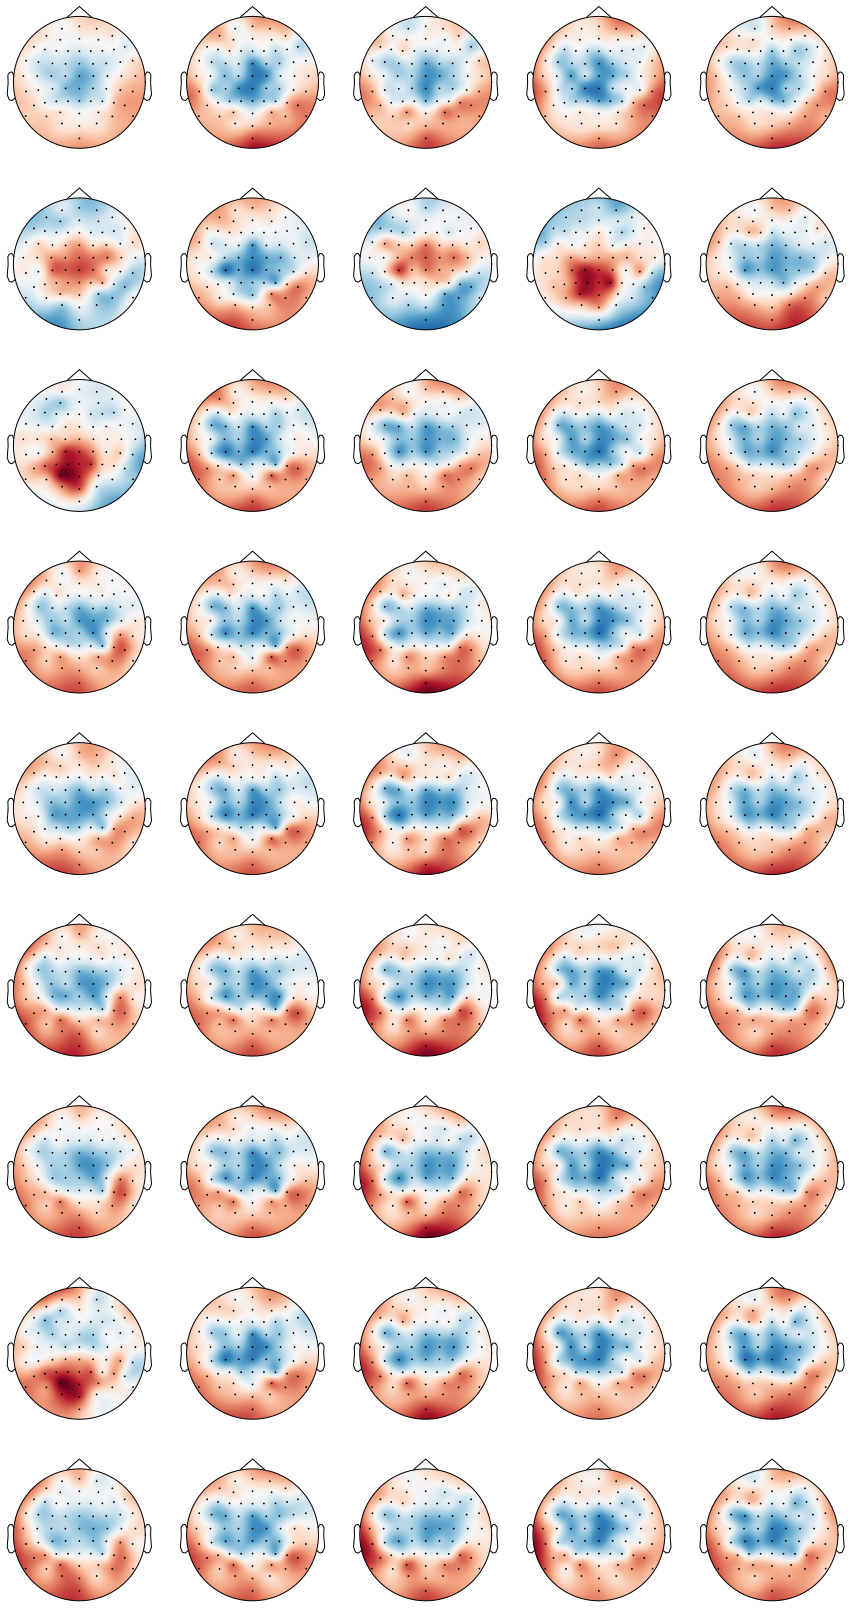

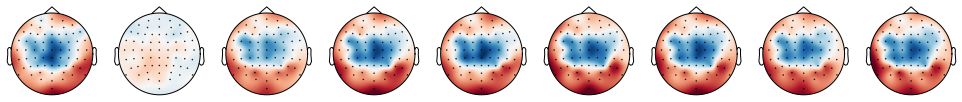

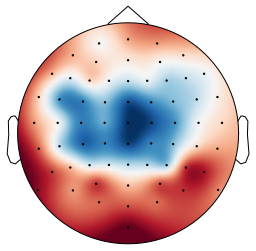

In [76]:
analyze_encoder_weights('raw_openmiir_siamese_simpleconv_dotprod')

In [10]:
print load_params('raw_openmiir_sce_simpleconv_dotprod')[0][0].keys()

['/pipeline/conv.W']


In [15]:
def load_temporal_filters(classifier, job, folds=None):
    if folds is None:
        folds = np.arange(9)

    fold_weights = np.concatenate([
            np.load('results/{}/{}_fold_{}_weights.npy'.format(job, classifier, f)) for f in folds],
            axis=0)

    return fold_weights

In [12]:
load_temporal_filters('simple_nn', 'raw_openmiir_sce_simpleconv_dotprod').mean(axis=0).shape

(3518, 12)

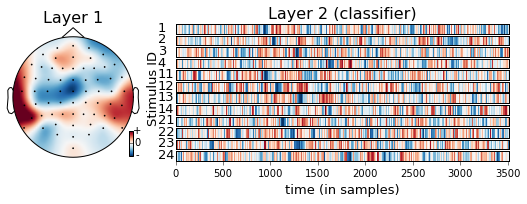

In [24]:
def plot_average_model(job, small=True, filename=None):
    fontsize1 = 16
    
    STIMULUS_IDS = [1,2,3,4,11,12,13,14,21,22,23,24]
    
    l1_weights = load_params(job, '/pipeline/conv.W')
    l1_weights = np.asarray(l1_weights)
    
    l1_polarity = np.sign(l1_weights[:,:,0,14,0,0])
    
    for i in range(l1_polarity.shape[0]):
        for j in range(l1_polarity.shape[1]):
            l1_weights[i,j] *= l1_polarity[i,j]
            
    l2_weights = load_temporal_filters('simple_nn', job)

    if small:
        fig = plt.figure(figsize=(9,2.3))
    else:
        fig = plt.figure(figsize=(16,4))

    subplot_grid = gridspec.GridSpec(12,30)

    # Layer 1
    axes = plt.subplot(subplot_grid[:,:8])
    W_topo = l1_weights.mean(axis=0).mean(axis=0).squeeze()

    layout = mne.channels.read_layout('biosemi.lay')
    mne.viz.plot_topomap(W_topo, layout.pos, names=layout.names, axes=axes, contours=None, show=False)
    

    if small:
        axes.set_title('Layer 1', fontsize=fontsize1)
        axes.text(0.61, 0.30, 'Stimulus ID', rotation=90, fontsize=13)
    else:
        axes.set_title('Layer 1 (encoder)', fontsize=fontsize1)
        axes.text(0.66, 0.20, 'Stimulus ID', rotation=90, fontsize=fontsize1)

    # colormap inlay
    ax = axes
    import matplotlib as mpl
    from mpl_toolkits.axes_grid1.inset_locator import inset_axes
    cax = inset_axes(ax,
                 width="3%",
                 height="20%",
                 bbox_transform=ax.transAxes,
                 bbox_to_anchor=(-0.05, -0.7, 1.05, 0.95),
                 loc= 1)
    norm = mpl.colors.Normalize(vmin=-1, vmax=1)
    cbar = mpl.colorbar.ColorbarBase(cax, 
                        cmap='RdBu_r', norm=norm, 
                        orientation='vertical')
    cbar.set_ticks([-1,0,1])
    cbar.set_ticklabels(['-','0','+'])
    for t in cbar.ax.get_yticklabels():
        t.set_horizontalalignment('center') 

    axes = plt.subplot(subplot_grid[0,10:])
    axes.set_title('Layer 2 (classifier)', fontsize=fontsize1)
    # axes.text(0.63, 0.25, 'Layer 2 (classifier)', rotation=90, fontsize=fontsize1)

    # Layer 2
    W_topo = l2_weights.mean(axis=0).T
    for i, s in enumerate(STIMULUS_IDS):
        W = np.atleast_2d(W_topo[i].squeeze())
        vmax = abs(W).max()
        axes = plt.subplot(subplot_grid[i,10:])
        axes.imshow(W, interpolation='nearest', cmap='RdBu_r', aspect='auto', vmax=vmax, vmin=-vmax)
        axes.set_yticks([])
        
        if small:
            axes.text(-190, 0.3, str(s), fontsize=13)
        else:
            axes.text(-140, 0.3, str(s), fontsize=14)

        if i == 11:
            axes.set_xlabel('time (in samples)', fontsize=13)
            axes.get_xaxis().set_tick_params(direction='out', top=False)
        else:
            axes.set_xticks([])

    if filename is not None:
        fig.savefig(filename, bbox_inches='tight', dpi=300)
    
plot_average_model('raw_openmiir_sce_simpleconv_dotprod')

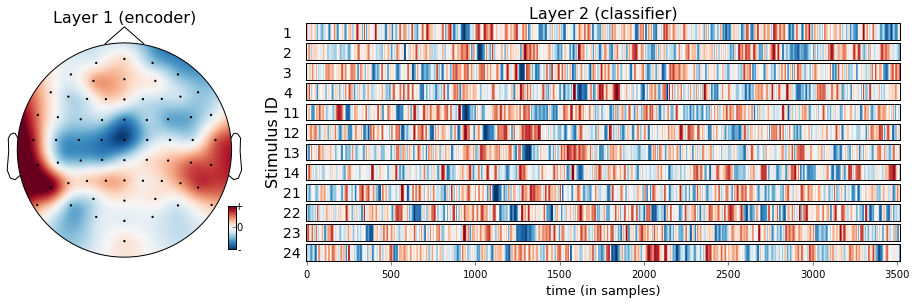

In [25]:
plot_average_model('raw_openmiir_sce_simpleconv_dotprod', small=False, filename='model_sce_big.pdf')

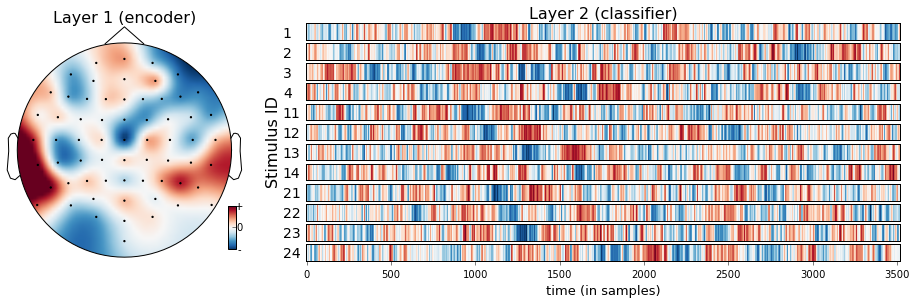

In [26]:
plot_average_model('raw_openmiir_tripletnet_simpleconv', small=False)

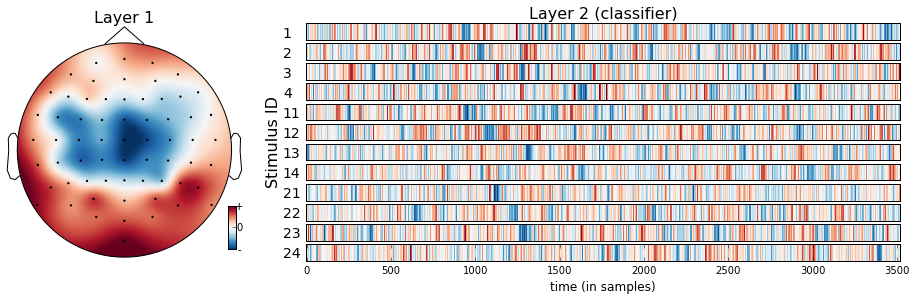

In [98]:
plot_average_model('raw_openmiir_siamese_simpleconv_dotprod')

In [ ]:
TODO: end-2-end NN

# confusion matrices

In [145]:
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt

STIMULUS_IDS = [1,2,3,4,11,12,13,14,21,22,23,24]

def plot_confusion(result, labels=STIMULUS_IDS, verbose=False, title=None,
                       axes=None, show=True, filename=None):
    y_real = result.test_Y_real
    y_pred = result.test_Y_pred
    
    accuracy = 100. * float(sum(y_pred == y_real)) / len(y_real)   
    confusion = confusion_matrix(y_real, y_pred)
    
    vmax = len(y_real) // confusion.shape[0]
    
    if axes is None:
        axes = plt.gca()
    
    axes.imshow(confusion, interpolation='nearest', cmap='binary', vmin=0, vmax=vmax)
    axes.set_ylabel('True Label', fontsize=12)
    axes.set_xlabel('Predicted Label', fontsize=12)
#     axes = plt.gca()
    
    if title is not None:
        axes.set_title('{} ({:.2f}%)'.format(title, accuracy), fontsize=14)
    else:
        axes.set_title('accuracy = {:.2f}%'.format(accuracy))
        
    if labels is not None:
        axes.set_xticks(xrange(len(labels)))
        axes.set_yticks(xrange(len(labels)))

        axes.set_xticklabels(labels, fontsize=9)
#         axes.set_xticklabels(labels, rotation=90, fontsize=10)
#         axes.set_yticklabels(labels, rotation=90, fontsize=10)
        axes.set_yticklabels(labels, fontsize=9)

    if filename is not None:
        fig = plt.gcf()
        fig.savefig(filename, bbox_inches='tight', dpi=300)
        
    if show:
        plt.show()

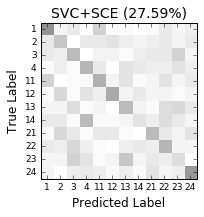

In [146]:
plt.figure(figsize=(2.8,2.8))
axes = plt.gca()
plot_confusion(results['SVC_SCE'], title='SVC+SCE', axes=axes, filename='confusion_SVC.pdf')

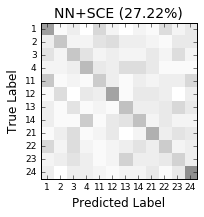

In [147]:
plt.figure(figsize=(2.8,2.8))
axes = plt.gca()
plot_confusion(results['MLP_SCE'], title='NN+SCE', axes=axes, filename='confusion_NN.pdf')

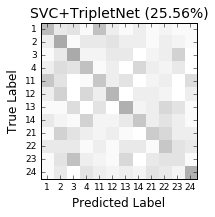

In [148]:
plt.figure(figsize=(2.8,2.8))
axes = plt.gca()
plot_confusion(results['SVC_TripletNet'], title='SVC+TripletNet', axes=axes, filename='confusion_TripletNet.pdf')